In [1]:
## from ctypes import *
#ctypes.cdll.LoadLibrary('')
#lib1 = CDLL("deps/sparse_rrt/deps/trajopt/build/lib/libsco.so")
#lib2 = CDLL("deps/sparse_rrt/deps/trajopt/build/lib/libutils.so")

import sys
sys.path.append('deps/sparse_rrt')
sys.path.append('.')

from sparse_rrt.planners import SST
#from env.cartpole_obs import CartPoleObs
#from env.cartpole import CartPole
#from sparse_rrt.systems.cartpole import Cartpole
from sparse_rrt.systems import standard_cpp_systems
from sparse_rrt import _sst_module
import numpy as np
import time
from tools.pcd_generation import rectangle_pcd
from plan_utility.line_line_cc import *
import pickle
obs_list = []
LENGTH = 20.
width = 6.
near = width * 1.2
# convert from obs to point cloud
# load generated point cloud
obs_list_total = []
obc_list_total = []
for i in range(10):
    file = open('/media/arclabdl1/HD1/YLmiao/YLmiao_from_unicorn/YLmiao/data/kinodynamic/cartpole_obs/obs_%d.pkl' % (i), 'rb')
    obs_list_total.append(pickle.load(file))
    file = open('/media/arclabdl1/HD1/YLmiao/YLmiao_from_unicorn/YLmiao/data/kinodynamic/cartpole_obs/obc_%d.pkl' % (i), 'rb')
    obc_list_total.append(pickle.load(file))

#[(0, 932), (1, 935), (2, 923), (8, 141), (5,931), (6, 969), (7, 927)]
# (5,931), (6, 286)
obs_idx = 3

p_idx = 1829
# Create custom system
#obs_list = [[-10., -3.],
#            [0., 3.],
#            [10, -3.]]
obs_list = obs_list_total[obs_idx]
obc_list = obc_list_total[obs_idx]
print('generated.')
print(obs_list.shape)

generated.
(7, 2)


In [2]:
# search for goal
"""
for p_idx in range(900, 1000):
    sgs = open('/media/arclabdl1/HD1/YLmiao/data/kinodynamic/acrobot_obs_backup/%d/start_goal_%d.pkl' % (obs_idx, p_idx), 'rb')
    sgs = pickle.load(sgs)
    dis = np.abs(sgs[1]-np.array([np.pi, 0, 0., 0.]))
    if dis[0] >= np.pi:
        dis[0] = 2*np.pi - dis[0]
    if dis[1] >= np.pi:
        dis[1] = 2*np.pi - dis[1]
        
    if np.linalg.norm(dis) <= 1e-1:
        break
print(p_idx)
"""

"\nfor p_idx in range(900, 1000):\n    sgs = open('/media/arclabdl1/HD1/YLmiao/data/kinodynamic/acrobot_obs_backup/%d/start_goal_%d.pkl' % (obs_idx, p_idx), 'rb')\n    sgs = pickle.load(sgs)\n    dis = np.abs(sgs[1]-np.array([np.pi, 0, 0., 0.]))\n    if dis[0] >= np.pi:\n        dis[0] = 2*np.pi - dis[0]\n    if dis[1] >= np.pi:\n        dis[1] = 2*np.pi - dis[1]\n        \n    if np.linalg.norm(dis) <= 1e-1:\n        break\nprint(p_idx)\n"

In [3]:
# load path
path = open('/media/arclabdl1/HD1/YLmiao/YLmiao_from_unicorn/YLmiao/data/kinodynamic/cartpole_obs/%d/path_%d.pkl' % (obs_idx, p_idx), 'rb')
path = pickle.load(path)
controls = open('/media/arclabdl1/HD1/YLmiao/YLmiao_from_unicorn/YLmiao/data/kinodynamic/cartpole_obs/%d/control_%d.pkl' % (obs_idx, p_idx), 'rb')
controls = pickle.load(controls)
costs = open('/media/arclabdl1/HD1/YLmiao/YLmiao_from_unicorn/YLmiao/data/kinodynamic/cartpole_obs/%d/cost_%d.pkl' % (obs_idx, p_idx), 'rb')
costs = pickle.load(costs)
sgs = open('/media/arclabdl1/HD1/YLmiao/YLmiao_from_unicorn/YLmiao/data/kinodynamic/cartpole_obs/%d/start_goal_%d.pkl' % (obs_idx, p_idx), 'rb')
sgs = pickle.load(sgs)

In [4]:
from plan_utility.line_line_cc import line_line_cc

def IsInCollision(x, obc, obc_width=4.):
    I = 10
    L = 2.5
    M = 10
    m = 5
    g = 9.8
    H = 0.5

    STATE_X = 0
    STATE_V = 1
    STATE_THETA = 2
    STATE_W = 3
    CONTROL_A = 0

    MIN_X = -30
    MAX_X = 30
    MIN_V = -40
    MAX_V = 40
    MIN_W = -2
    MAX_W = 2


    if x[0] < MIN_X or x[0] > MAX_X:
        return True

    H = 0.5
    pole_x1 = x[0]
    pole_y1 = H
    pole_x2 = x[0] + L * np.sin(x[2])
    pole_y2 = H + L * np.cos(x[2])


    for i in range(len(obc)):
        for j in range(0, 8, 2):
            x1 = obc[i][j]
            y1 = obc[i][j+1]
            x2 = obc[i][(j+2) % 8]
            y2 = obc[i][(j+3) % 8]
            if line_line_cc(pole_x1, pole_y1, pole_x2, pole_y2, x1, y1, x2, y2):
                return True
    return False


In [5]:
def wrap_angle(x, system):
    circular = system.is_circular_topology()
    res = np.array(x)
    for i in range(len(x)):
        if circular[i]:
            # use our previously saved version
            res[i] = x[i] - np.floor(x[i] / (2*np.pi))*(2*np.pi)
            if res[i] > np.pi:
                res[i] = res[i] - 2*np.pi
    return res


In [6]:
from visual.visualizer import Visualizer
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
class CartpoleVisualizer(Visualizer):
    def __init__(self, system, params):
        super(CartpoleVisualizer, self).__init__(system, params)
        self.dt = 2
        self.fig1 = plt.figure(figsize=(25,6))
        self.fig2 = plt.figure(figsize=(25,20))
        self.ax1 = self.fig1.add_subplot(1,1,1)
        self.ax2 = self.fig2.add_subplot(1,1,1)

        #self.fig = plt.gcf()
        #self.fig.set_figheight(3)
        #self.fig.set_figwidth(30)
        #self.ax1 = plt.subplot(121)
        #self.ax2 = plt.subplot(122)
    def _init(self):
        ##### handle the animation
        # clear the current ax
        print("in init")
        ax = self.ax1
        ax.clear()
        # add patches
        state = self.states[0]
        self.pole = patches.Rectangle((state[0]-self.params['pole_w']/2,self.params['cart_h']),\
                                       self.params['pole_w'],self.params['pole_l'],\
                                      linewidth=.5,edgecolor=self.color_dict['pole_start_color'],\
                                      facecolor=self.color_dict['pole_start_color'])
        self.cart = patches.Rectangle((state[0]-self.params['cart_w']/2,0),\
                                       self.params['cart_w'],self.params['cart_h'],\
                                      linewidth=.5,edgecolor=self.color_dict['cart_start_color'],\
                                      facecolor=self.color_dict['cart_start_color'])
        self.recs = []
        self.recs.append(self.pole)
        self.recs.append(self.cart)
        for i in range(len(self.obs)):
            x, y = self.obs[i]
            obs = patches.Rectangle((x-self.params['obs_w']/2,y-params['obs_h']/2),\
                                       self.params['obs_w'],self.params['obs_h'],\
                                      linewidth=.5,edgecolor=self.color_dict['obstacle_color'],\
                                      facecolor=self.color_dict['obstacle_color'])
            self.recs.append(obs)
            ax.add_patch(obs)
        # transform pole according to state
        t = mpl.transforms.Affine2D().rotate_deg_around(state[0], self.params['cart_h'], \
                                                        -state[2]/np.pi * 180) + ax.transData
        self.pole.set_transform(t)
        ax.add_patch(self.pole)
        ax.add_patch(self.cart)

        #### handle search space
        ax = self.ax2
        ax.clear()
        ax.set_xlim(-25, 25)
        ax.set_ylim(-np.pi, np.pi)

        dx = 1
        dtheta = 0.1
        feasible_points = []
        infeasible_points = []
        imin = 0
        imax = int(2*30./dx)
        jmin = 0
        jmax = int(2*np.pi/dtheta)

        for i in range(imin, imax):
            for j in range(jmin, jmax):
                x = np.array([dx*i-30, 0., dtheta*j-np.pi, 0.])
                if IsInCollision(x, self.cc_obs):
                    infeasible_points.append(x)
                else:
                    feasible_points.append(x)
        feasible_points = np.array(feasible_points)
        infeasible_points = np.array(infeasible_points)
        
        print('feasible points')
        print(feasible_points)
        print('infeasible points')
        print(infeasible_points)
        #scat_feas =ax.scatter(feasible_points[:,0], feasible_points[:,2], c='yellow')
        scat_infeas = ax.scatter(infeasible_points[:,0], infeasible_points[:,2], c=self.color_dict['obstacle_color'])

        #self.recs.append(scat_feas)
        self.recs.append(scat_infeas)

        scat_state = ax.scatter(state[0], state[2], c=self.color_dict['state_start_color'])
        self.recs.append(scat_state)
        print("after init")

        return self.recs
    def _animate(self, i):
        print('animating, frame %d/%d' % (i, self.total))
        
        ax = self.ax1
        ax.set_xlim(-25, 25)
        ax.set_ylim(-6, 6)
        state = self.states[i]
        self.recs[0].set_xy((state[0]-self.params['pole_w']/2,self.params['cart_h']))
        t = mpl.transforms.Affine2D().rotate_deg_around(state[0], self.params['cart_h'], \
                                                        -state[2]/np.pi * 180) + ax.transData
        self.recs[0].set_transform(t)
        self.recs[1].set_xy((state[0]-self.params['cart_w']/2,0))


        # handle search space
        ax = self.ax2
        ax.set_xlim(-25, 25)
        ax.set_ylim(-np.pi, np.pi)
        self.recs[-1].set_offsets([state[0], state[2]])
        # print location of cart
        return self.recs


    def animate(self, states, actions, costs, obstacles, sg, wrap_system):
        '''
        given a list of states, actions and obstacles, animate the robot
        '''

        new_obs_i = []
        obs_width = 4.0
        for k in range(len(obstacles)):
            obs_pt = []
            obs_pt.append(obstacles[k][0]-obs_width/2)
            obs_pt.append(obstacles[k][1]-obs_width/2)
            obs_pt.append(obstacles[k][0]-obs_width/2)
            obs_pt.append(obstacles[k][1]+obs_width/2)
            obs_pt.append(obstacles[k][0]+obs_width/2)
            obs_pt.append(obstacles[k][1]+obs_width/2)
            obs_pt.append(obstacles[k][0]+obs_width/2)
            obs_pt.append(obstacles[k][1]-obs_width/2)
            new_obs_i.append(obs_pt)
        obs_i = new_obs_i
        self.cc_obs = obs_i

        # transform the waypoint states and actions into trajectory
        traj = []
        s = states[0]
        for i in range(len(states)-1):
            print('state: %d, remaining: %d' % (i, len(states)-i))
            
            
            action = actions[i]
            # number of steps for propagtion
            #num_steps = int(np.round(costs[i]/self.params['integration_step']))
            num_steps = 100000
            for j in range(num_steps):
                traj.append(np.array(s))
                #print("porpagating...")
                #print(s)
                #print('st:')
                #print(sT)
                s = self.system(s, action, self.params['integration_step'])
                assert not IsInCollision(s, obs_i)
                if np.linalg.norm(s - states[i+1]) <= 1e-3:
                    break

        return np.array(traj)
    
    
    # plot the trajectory
    def plot(self, traj, obstacles, sg, color_dict, wrap_system):
        self.fig1 = plt.figure(figsize=(25,6))
        self.fig2 = plt.figure(figsize=(25,20))
        self.ax1 = self.fig1.add_subplot(1,1,1)
        self.ax2 = self.fig2.add_subplot(1,1,1)
        self.color_dict = color_dict
        print("animating...")
        # animate
        self.states = traj
        self.obs = obstacles
        print(len(self.states))
        self.total = len(self.states)
        self._init()
        
        to_plot_list_x = []
        to_plot_list_y = []
        traj_recs = []
        plot_step_sz = 50
        for i in list(range(1,len(traj))) + [0]:
            if i % plot_step_sz == 0:
                # plot the scene change
                if i == 0:
                    pole_color = color_dict["pole_start_color"]
                    cart_color = color_dict["cart_start_color"]
                elif i+plot_step_sz >= len(traj):
                    pole_color = color_dict["pole_goal_color"]
                    cart_color = color_dict["cart_goal_color"]
                else:
                    pole_color = color_dict["pole_intermediate_color"]
                    cart_color = color_dict["cart_intermediate_color"]
                state = traj[i]
                pole = patches.Rectangle((state[0]-self.params['pole_w']/2,self.params['cart_h']),\
                                               self.params['pole_w'],self.params['pole_l'],\
                                              linewidth=.5,edgecolor=pole_color,facecolor=pole_color)
                cart = patches.Rectangle((state[0]-self.params['cart_w']/2,0),\
                                               self.params['cart_w'],self.params['cart_h'],\
                                              linewidth=.5,edgecolor=cart_color,facecolor=cart_color)

                traj_recs.append(pole)
                traj_recs.append(cart)
                ax = self.ax1
                ax.set_xlim(-25, 25)
                ax.set_ylim(-6, 6)
                ax.add_patch(pole)
                ax.add_patch(cart)
                pole.set_xy((state[0]-self.params['pole_w']/2,self.params['cart_h']))
                t = mpl.transforms.Affine2D().rotate_deg_around(state[0], self.params['cart_h'], \
                                                                -state[2]/np.pi * 180) + ax.transData
                pole.set_transform(t)
                cart.set_xy((state[0]-self.params['cart_w']/2,0))
                ax.axis('off')

            # plot in the state space    
            ax = self.ax2
            traj_to_plot = wrap_angle(traj[i], wrap_system)
            scat_state = ax.scatter(traj_to_plot[0], traj_to_plot[2], c=color_dict["state_intermediate_color"], s=25.0)
        colors = [color_dict["state_start_color"], color_dict["state_goal_color"]]
        
        #ax = self.ax1
        #cm = LinearSegmentedColormap.from_list("Custom", colors, N=len(to_plot_list_x))
        """
        for i in range(len(to_plot_list_x)):
            #ax.plot(to_plot_list_x[i], to_plot_list_y[i], alpha=float(i)/len(to_plot_list_x), c=cm(float(i)/len(to_plot_list_x)))
            if i == 0:
                ax.plot(to_plot_list_x[i], to_plot_list_y[i], alpha=1, c='green')
            else:
                ax.plot(to_plot_list_x[i], to_plot_list_y[i], alpha=float(i)/len(to_plot_list_x), c='blue')
        """
            
        # start and goal
        ax = self.ax2
        scat_state = ax.scatter(sg[0][0], sg[0][2], c=color_dict["state_start_color"], s=200.0)
        scat_state = ax.scatter(sg[1][0], sg[1][2], c=color_dict["state_goal_color"], s=200.0, marker='*')
        plt.subplots_adjust(wspace=0, hspace=0)

        ax.axis('off')

        #plt.savefig("cartpole_mpnettree_%d_p_%d.png" % (obs_idx, p_idx), bbox_inches='tight')
        return self.fig1, self.fig2
        
        
        """
        # for thesis
        fig = plt.figure()
        ax = plt.subplot(121)
        ax.set_xlim(-40, 40)
        ax.set_ylim(-40, 40)
        fig.set_figheight(5)
        fig.set_figwidth(10)
        
        for i in range(len(self.obs)):
            x, y = self.obs[i]
            obs = patches.Rectangle((x-self.params['obs_w']/2,y-params['obs_h']/2),\
                                       self.params['obs_w'],self.params['obs_h'],\
                                      linewidth=.5,edgecolor='black',facecolor='black')
            self.recs.append(obs)
            ax.add_patch(obs)
        ax.plot(to_plot_list_x[0], to_plot_list_y[0], alpha=1, c='green')
        ax.plot(to_plot_list_x[-1], to_plot_list_y[-1], alpha=1, c='red')
        
        ax = plt.subplot(122)
        ax.set_xlim(-np.pi, np.pi)
        ax.set_ylim(-np.pi, np.pi)
        dtheta = 0.1
        feasible_points = []
        infeasible_points = []
        imin = 0
        imax = int(2*np.pi/dtheta)

        for i in range(imin, imax):
            for j in range(imin, imax):
                x = np.array([dtheta*i-np.pi, dtheta*j-np.pi, 0., 0.])
                if IsInCollision(x, self.cc_obs):
                    infeasible_points.append(x)
                else:
                    feasible_points.append(x)
        feasible_points = np.array(feasible_points)
        infeasible_points = np.array(infeasible_points)

        print('feasible points')
        print(feasible_points)
        print('infeasible points')
        print(infeasible_points)
        #scat_feas =ax.scatter(feasible_points[:,0], feasible_points[:,1], c='white')
        scat_infeas = ax.scatter(infeasible_points[:,0], infeasible_points[:,1], c='black')
        scat_state = ax.scatter(sg[0][0], sg[0][1], c='green', s=50.0)
        scat_state = ax.scatter(sg[1][0], sg[1][1], c='red', s=50.0, marker='*')
        """


states:
[[ 2.16127925e+01  0.00000000e+00  1.52666725e+00  0.00000000e+00]
 [ 2.15266044e+01 -1.34317518e+00  1.50323557e+00 -3.64510027e-01]
 [ 2.12751806e+01 -3.34446150e+00  1.44958128e+00 -6.28488365e-01]
 [ 2.13279335e+01  4.04260818e+00  8.87157434e-01 -2.00000000e+00]
 [ 2.18153538e+01  5.95320426e+00  6.91157434e-01 -2.00000000e+00]
 [ 2.27898532e+01 -8.33922733e-01  1.99934932e-01 -5.23952891e-01]
 [ 2.14549659e+01 -7.05208333e+00  3.04809373e-01  1.11534376e+00]
 [ 1.84398901e+01 -1.25129128e+01  8.20038949e-01  2.00000000e+00]
 [ 1.62077330e+01 -1.50342774e+01  1.14339502e+00  1.97120437e+00]
 [ 1.38022290e+01 -1.70809122e+01  1.42287109e+00  1.71932032e+00]
 [ 6.44582627e+00 -2.31639598e+01  1.84525277e+00  4.39768379e-01]
 [-1.00294059e-02 -2.01522292e+01  1.89181615e+00 -1.22920016e-01]
 [-2.03574309e+00 -1.95539079e+01  1.86768005e+00 -3.55772735e-01]
 [-6.42180980e+00 -1.52040183e+01  1.72983959e+00 -7.73447627e-01]
 [-8.69760817e+00 -1.21525311e+01  1.56970889e+00 -1.1

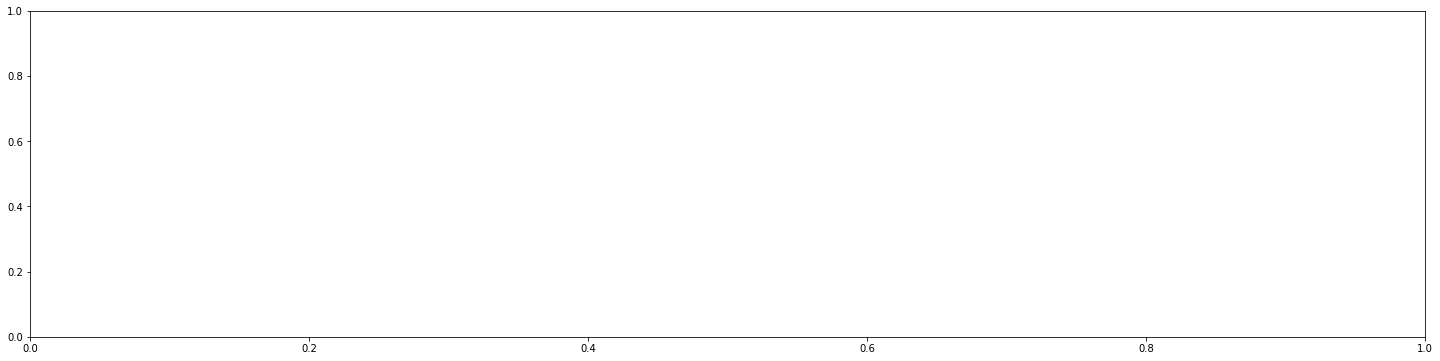

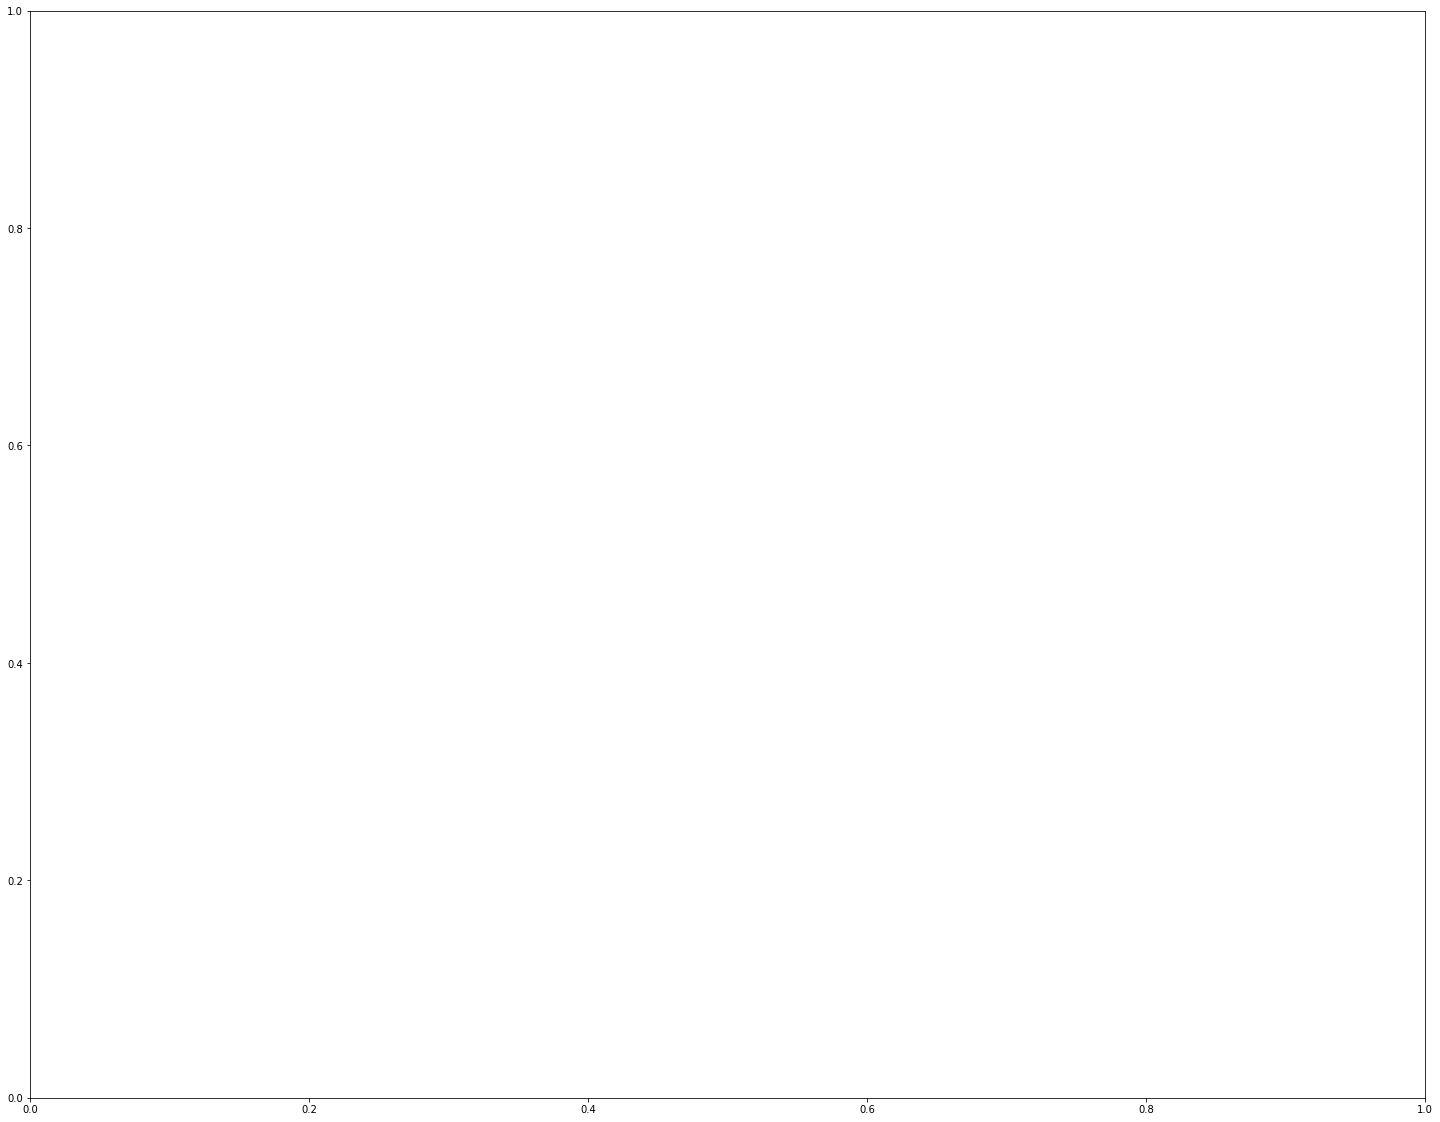

In [7]:
params = {}
params['pole_l'] = 2.5
params['pole_w'] = 0.01
params['cart_w'] = 1.
params['cart_h'] = 0.5
params['obs_w'] = 4
params['obs_h'] = 4
params['integration_step'] = 0.002

system = _sst_module.PSOPTCartPole()
cpp_propagator = _sst_module.SystemPropagator()
dynamics = lambda x, u, t: cpp_propagator.propagate(system, x, u, t)

vis = CartpoleVisualizer(dynamics, params)
states = path
actions = controls
sgs[0] = wrap_angle(sgs[0], system)
sgs[1] = wrap_angle(sgs[1], system)
print('states:')
print(states)
traj = vis.animate(np.array(states), np.array(actions), np.array(costs), obs_list, np.array(sgs), system)
#HTML(anim.to_html5_video())
#anim.save('acrobot_env%d_path%d.mp4' % (obs_idx, p_idx))

animating...
3951
in init


/home/arclabdl1/YLmiao/kinodynamics/KinoMPNet/plan_utility/line_line_cc.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  uA = ((x4-x3)*(y1-y3) - (y4-y3)*(x1-x3)) / ((y4-y3)*(x2-x1) - (x4-x3)*(y2-y1))
/home/arclabdl1/YLmiao/kinodynamics/KinoMPNet/plan_utility/line_line_cc.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  uB = ((x2-x1)*(y1-y3) - (y2-y1)*(x1-x3)) / ((y4-y3)*(x2-x1) - (x4-x3)*(y2-y1))


feasible points
[[-30.           0.          -3.14159265   0.        ]
 [-30.           0.          -3.04159265   0.        ]
 [-30.           0.          -2.94159265   0.        ]
 ...
 [ 29.           0.           2.75840735   0.        ]
 [ 29.           0.           2.85840735   0.        ]
 [ 29.           0.           2.95840735   0.        ]]
infeasible points
[[-19.           0.           0.75840735   0.        ]
 [-19.           0.           0.85840735   0.        ]
 [-19.           0.           0.95840735   0.        ]
 ...
 [ 12.           0.          -1.04159265   0.        ]
 [ 12.           0.          -0.94159265   0.        ]
 [ 12.           0.          -0.84159265   0.        ]]
after init


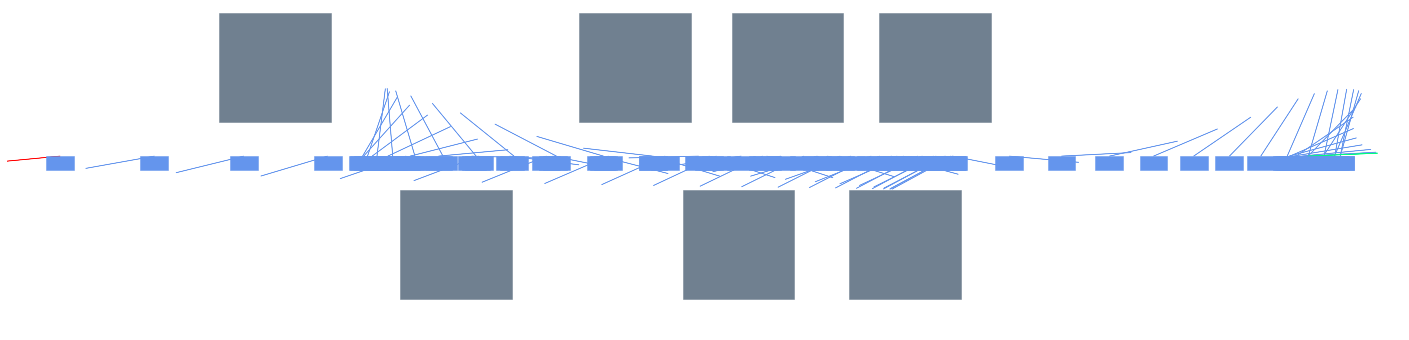

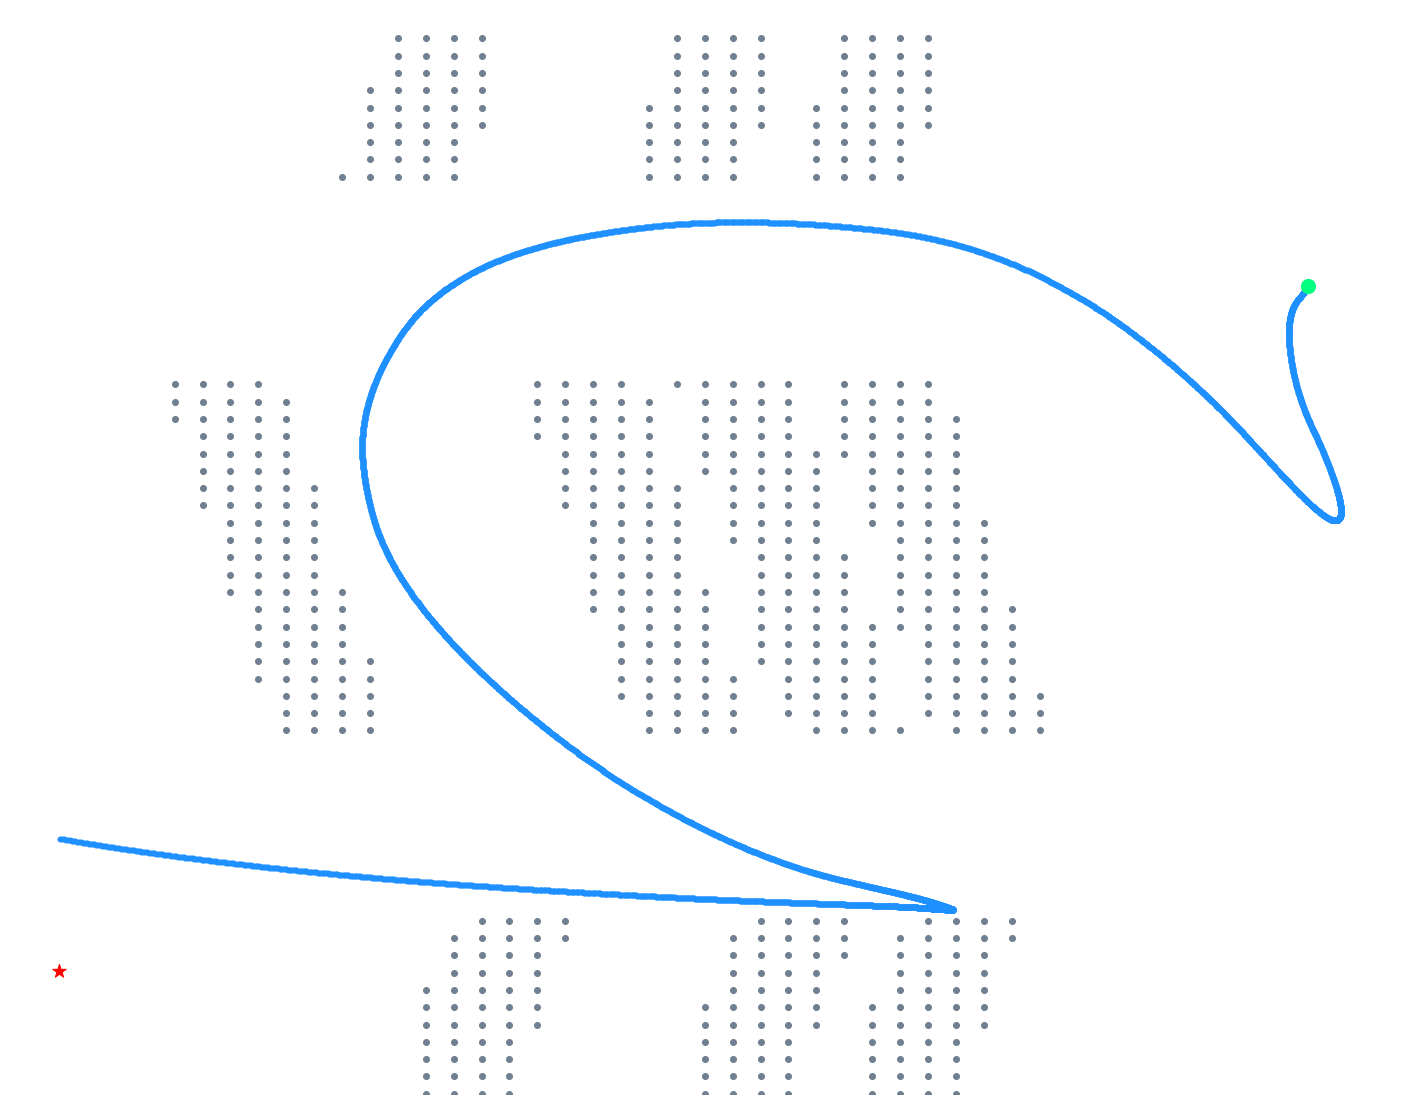

In [8]:
color_dict = {'state_start_color': 'springgreen', 'state_intermediate_color': 'dodgerblue', 'state_goal_color': 'red',
              'pole_start_color': 'springgreen', 'pole_intermediate_color': 'cornflowerblue', 'pole_goal_color': 'red',
              'cart_start_color': 'cornflowerblue', 'cart_intermediate_color': 'cornflowerblue', 'cart_goal_color': 'cornflowerblue',
              'obstacle_color': 'slategray'}
fig1, fig2 = vis.plot(traj, obs_list, np.array(sgs), color_dict, system)
fig1.savefig("cartpole_sst_%d_p_%d_workspace.pdf" % (obs_idx, p_idx), bbox_inches='tight', pad_inches = 0)
fig2.savefig("cartpole_sst_%d_p_%d_statespace.pdf" % (obs_idx, p_idx), bbox_inches='tight', pad_inches = 0)
fig1.show()
fig2.show()


In [9]:
print(obs_idx)
print(p_idx)

3
1829


(7, 1400, 2)
(9800, 2)


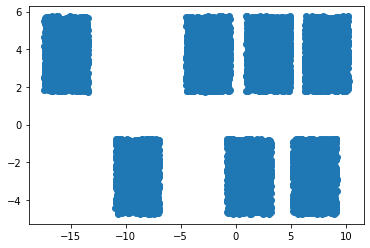

In [10]:
# visualize point cloud
import matplotlib.pyplot as plt
print(obc_list.shape)
obc_all = np.concatenate(obc_list_total[obs_idx], axis=0)
print(obc_all.shape)
plt.scatter(obc_all[:,0], obc_all[:,1])
plt.show()

(9800, 2)


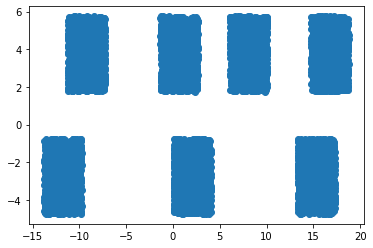

(9800, 2)


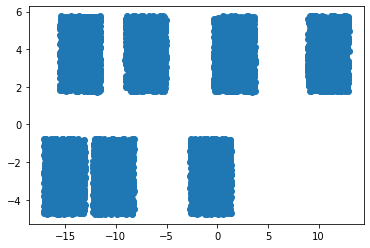

In [11]:
for i in range(2):
    obc_all = np.concatenate(obc_list_total[i], axis=0)
    print(obc_all.shape)
    plt.scatter(obc_all[:,0], obc_all[:,1])
    plt.show()